<a href="https://colab.research.google.com/github/XiaotingLiu620/Project1/blob/main/Ligand_based_machine_learning/LBML_and_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Screening for EGFR ligands using machine learning

**Note:** this exercise is based on T7 from [TeachOpenCADD](https://doi.org/10.1186/s13321-019-0351-x).

Contributors:

* Albert J. Kooistra, 2022, [University of Copenhagen](https://drug.ku.dk/staff/?pure=en/persons/612712)
* Andrea Volkamer & Talia B. Kimber, 2019-2020, [Volkamer lab](https://volkamerlab.org)
* Jacob Gora & Jan Philipp Albrecht, CADD seminar 2018, Charité/FU Berlin


## Aim of this practical

Machine learning (ML) has gained quite a momentum in drug discovery and especially in ligand-based virtual screening / predictive modeling. In this tutorial, you will learn how to use different supervised ML algorithms to predict the activity of novel compounds against a protein target of interest (EGFR) based on a training set of known active and inactive compounds.

### Techniques you will use:

* Data preparation:
    * Loading and checking input data
    * Splitting the dataset into active and inactive molecules
    * Encoding the structure of small molecules into fingerprints
* Supervised Machine learning
    * Random forest
    * Artificial neural network
    * Training ML models
* Model validation and evaluation
    * Evaluating ML models
    * Performance measures
    * ROC plots
* Prediction of new molecules: applying the trained models

## Practical

### Before we get started

Note that some of the boxes (i.e. cells) in this notebook are "hidden" by default, you can simply click on the gray bar to view them. You can also click on *View* at the top then click on *Expand Sections* to show all cells. For some computers this might be a bit too much, but you can always hide the cells again by clicking on *View* => *Collapse sections*.



### Setting up the environment

First, we will setup our coding environment by installing existing packages/libraries that we need to process the molecular and small molecule data, generate the fingerprints and to create our machine learning models. Simply execute/play the (hidden) code cells below to get started, this might take a few minutes.


In [32]:
!pip install rdkit-pypi -qqq
!pip install mols2grid -qqq

In [33]:
from pathlib import Path
from warnings import filterwarnings
from IPython.display import Javascript
import sys
import time

import pandas as pd
import numpy as np
import mols2grid
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

# Silence some expected warnings
filterwarnings("ignore")

# Fix seed for reproducible results
SEED = 6

In [34]:
# Set path to this notebook and create data folder
HERE = Path(_dh[-1])
DATA = HERE / "data"
!mkdir "data"

mkdir: cannot create directory ‘data’: File exists


## Data acquisition

###Loading our compound and activity data

Let's start by loading our data, which is a set of compounds that have been experimentally tested for their affinity on the **Epidermal growth factor receptor** (EGFR). The *csv* file from a repository is loaded into a dataframe with the important columns:

* CHEMBL-ID
* SMILES string of the corresponding compound
* Measured affinity: pIC50

In [35]:
# Read EGFR inhibitor data
chembl_df = pd.read_csv(
    "https://raw.githubusercontent.com/AJK-dev/course_materials/main/Ligand_based_machine_learning/data/EGFR_compounds_lipinski.csv",
    index_col=0,
)

# Let's take a look at first few data rows
print("Shape of dataframe : ", chembl_df.shape)
chembl_df.head()


Shape of dataframe :  (4635, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.2891,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.9333,True
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043257,5,1,3.5969,True
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.0122,True
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.5726,True


In the next step, we will do a bit of cleaning up and select only the data we want.

In [36]:
# Let's round all pIC50 values to one demical
chembl_df = chembl_df.round({'pIC50': 1})
# Select only the columns we want
chembl_df = chembl_df[["molecule_chembl_id", "smiles", "pIC50"]]

# And finally check the result
print("Shape of dataframe : ", chembl_df.shape)
chembl_df.head()


Shape of dataframe :  (4635, 3)


,molecule_chembl_id,smiles,pIC50
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.5
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.2
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.2
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.1
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.1


**Questions:**

*   What protein family does EGFR belong to (DISCUSS: what is its function)?
*   What is the endogenous small molecule ligand (not substrate) of EGFR?
*   Name one FDA-approved drug for EGFR and its therapeutic function
*   How many molecules do we have in our dataset?
*   DISCUSS: Why would we only keep these columns? Is more data not always better?

**🛑 CHECKPOINT**
*   Verify you have completed all questions in Absalon before continuing
*   If you are completely ready, check the checkbox and continue.

In [38]:
done_data = True #@param {type:"boolean"}
if not done_data:
  sys.exit()

Let's take a peak at a few of those ligands with a high activity

In [40]:
mols2grid.display(chembl_df.head(15), smiles_col="smiles")

MolGridWidget()

Let's also look at a few of the ligands that have very low/no affinity for the EGFR kinase

In [39]:
mols2grid.display(chembl_df.tail(15), smiles_col="smiles")

MolGridWidget()

**Questions:**
* DISCUSS: Can you already see some sort of a pattern in the molecules with a high affinity?
* DISCUSS: What about the low/no affinity molecules, are they lacking this pattern?
* Which group of the endogenous ligand of EGFR looks a bit similar?
NOTE: the machine learning models will try to identify such patterns in a similar way.

**🛑 CHECKPOINT**
*   Verify you have completed all questions in Absalon before continuing
*   If you are completely ready, check the checkbox and continue.

In [41]:
done_molecules = True #@param {type:"boolean"}
if not done_molecules:
  sys.exit()

## Data preparation

#### Data labeling
We need to classify each compound as active or inactive. Therefore, we use the pIC50 value.

* IC50 describes the concentration of the compound needed to inhibit a process (_in vitro_) by 50%.
* pIC50 = -log10(IC50)
* Note that the IC50 needs to be specified in **molar concentration**
* The pIC50 value we use to split the data differs from target to target and also depends on the data availability.

🛑 Specify the pIC50 equivalent of IC50 = 500 nM in the input box below up to a single decimal.


In [57]:
# Mark every molecule as 1 (active) with an IC50 <= 500 nM, otherwise inactive (0)
activity_cutoff = 6.3 #@param {type:"number"}
if activity_cutoff == None:
  display(Javascript("element.innerHTML = '<span style=\"color: red\"><b>ERROR:</b> check the specified activity cutoff</span>';"))
elif round(10**(7-1*activity_cutoff)) != 5:
    display(Javascript("element.innerHTML = '<span style=\"color: red\"><b>ERROR:</b> check the specified activity cutoff</span>';"))
    print("The value you provided corresponds to an IC50 of", round(10**(7-1*activity_cutoff)*100), "nM")
else:
  # Add column for activity
  chembl_df["active"] = 0

  # Define the compounds that meet the specified cutoff as "active" (1.0)
  chembl_df.loc[chembl_df[chembl_df.pIC50 >= round(activity_cutoff, 1)].index, "active"] = 1.0

  print("Number of active compounds:", int(chembl_df.active.sum()))
  print("Number of inactive compounds:", len(chembl_df) - int(chembl_df.active.sum()))

Number of active compounds: 2678
Number of inactive compounds: 1957


**Question:** What are the limitations/potential pitfalls of defining active and inactive molecules in this way?
**DISCUSS:** Is the resulting number of active and number of inactive molecules balanced? Is this important?


#### Molecule encoding

Now we define a function `smiles_to_fp` to generate fingerprints from SMILES.
For now, we will only use the simple dictionary based fingerpint called MACCS.

In [58]:
def smiles_to_fp(smiles):
    # Take the smiles and convert it to a molecule object
    mol = Chem.MolFromSmiles(smiles)

    # Calculate the MACCS fingerprint using the molecule object
    return np.array(MACCSkeys.GenMACCSKeys(mol))

In [59]:
# Make a copy of our dataset
compound_df = chembl_df.copy()

# Calculating the fingerprint and storing it in a new column called "FP"
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.head(3)


,molecule_chembl_id,smiles,pIC50,active,fp
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.5,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Question:** Read [this blog post](https://drzinph.com/computing-molecular-descriptors-intro/) to get a better understanding of what molecular fingerprints are. Also review the presentation slides before answering the questions below and continuing.

* What is MACCS for type of fingerprints and what does MACCS stand for?

* Click on the table icon in the top right corner of the table. You will now see a lot of zeros and ones in the "fp" column. How many bits does a MACCS fingerprint contain for each compound and what do these 0s and 1s represent?
  * Tip: the number of bits in the MACCS fingerprint is predefined and thus the same for each compound.
  * Note: in the table each compound has one more bit than usual, but this is because the first 0 is ignored.

--

**🛑 CHECKPOINT**
*   Verify you have completed all questions in Absalon before continuing
*   If you are completely ready, check the checkbox and continue.

In [60]:
done_fingerprints = True #@param {type:"boolean"}
if not done_fingerprints:
  sys.exit()

## Machine learning theory

To successfully apply ML, we need a large data set of molecules, a molecular encoding, a label per molecule in the data set, and a ML algorithm to train a model. Then, we can make predictions for new molecules.

![ML overview](https://github.com/AJK-dev/course_materials/blob/main/Ligand_based_machine_learning/images/ML_overview.png?raw=1)

_Figure 1_: Machine learning overview: Molecular encoding, label, ML algorithm, prediction. Figure by Andrea Volkamer.

### Machine learning (ML)

There are different types of machine learning algorithms (text adapted from [scikit-learn page](http://scikit-learn.org/stable/)), the most popular being:

* Regression (supervised): Prediction of a continuous-values attribute associated with an object
* Classification (supervised): Identify which category an object belongs to
* Clustering (unsupervised): Automated grouping of similar objects into sets
* Dimensionality reduction (unsupervised): Reducing the number of random variables to consider

### Machine Learning (ML) algorithms

Now we have arrived at the magic part 🧙‍♂️ of this exercise: building the machine learning models. As you heard in the lectures, there are a lot of different ML methods available. In the following, we will try out two very different ML approaches to build a good activity predictor for our molecules.

We will use:
* **Artificial neural networks (ANNs)**: An ANN is based on a collection of connected units or nodes called artificial neurons which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit a signal from one artificial neuron to another. An artificial neuron that receives a signal can process it and then signal additional artificial neurons connected to it. The output neurons indicate the probability that a molecule is either active or inactive.
* **Random Forest (RF)**: Ensemble of decision trees. A single decision tree splits the features of the input vector - in our case the bits of the fingerprints - in a way that maximizes an correct predictions. In the random forest algorithm a lot of different discision trees are generated, however these trees are de-correlated because the choice of features - the bits of the fingerprints - that a tree can use, are chosen randomly for each tree. The output of the random forest is a based on the prediction from all the trees (majority voting), i.e. the output with the most votes wins.

#![Voting](https://miro.medium.com/max/764/0*F4HiydKf6wBHBI5F)

_Figure 2_: Example of a random forest and majority voting. Figure taken from [KDnuggets](https://www.kdnuggets.com/2020/01/random-forest-powerful-ensemble-learning-algorithm.html).

**Questions:**
* In our case, we will try to predict wether a molecule has an affinity for EGFR or not. What is this type of machine learning called?
* Why can different trees in a random forest predict a different outcome?

**🛑 CHECKPOINT**
*   Verify you have completed all questions in Absalon before continuing
*   If you are completely ready, check the checkbox and continue.

In [61]:
done_ml_theory = True #@param {type:"boolean"}
if not done_ml_theory:
  sys.exit()

## Machine learning - training, validation and evaluation

#### Performance measures

| What the model predicts  | True active  |  True inactive |
|---|---|---|
| active  |  True Positive (TP) |  False Positive (FP) |
| inactive  |  False Negative (FN) |  True Negative (TN) |

* **Sensitivity**, also true positive rate (TPR)
    * TPR = TP/(FN + TP)
    * _Intuitively_: Out of all actual positives, how many were predicted as positive?
* **Specificity**, also true negative rate (TNR)
    * TNR = TN/(FP + TN)
    * _Intuitively_: Out of all actual negatives, how many were predicted as negative?
* **Accuracy**, also the trueness
    * ACC = (TP + TN)/(TP + TN + FP + FN)
    * _Intuitively_: Proportion of correct predictions.

--

* **ROC-curve**, receiver operating characteristic curve
    * A graphical plot that illustrates the diagnostic ability of our classifier
    * Plots the sensitivity (Y-axis) against 1 - specificity (X-axis)
* **AUC**, the area under the ROC curve (AUC):  
    * Describes the probability that a classifier will rank a randomly chosen positive instance higher than a negative one
    * Values between 0 and 1, the higher the better

**DISCUSS:** why are there so many metrics? Couldn't we, for example, simply use the *Sensitivity* and skip the rest?


#### Helper functions
The code in the cells below are Helper functions to evaluate the performance of our machine learning method. You can just execute the cells below.

Code inspired by [stackoverflow](https://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python).

In [62]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()
    fig.set_dpi(150)

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"{DATA}/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

Helper function to calculate model performance.

In [63]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

 Helper function to fit a machine learning model on a random train-test split of the data and return the performance measures.

In [64]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

**Preprocessing**: Split the data (will be reused for the other models)

In [65]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=np.random.RandomState(SEED))
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

# Clean start before machine learning
rf_models = []
nn_models = []

Training data size: 3708
Test data size: 927


#### Random forest classifier

We start with a random forest model, where we first set the parameters.

We train the model on a random train-test split and plot the evaluation results.

**NOTE:** the value displayed next to the slider isn't always updated correctly, check the code to see if the correct value has been selected!

In [67]:
number_of_trees = 3 #@param {type:"slider", min:1, max:100, step:1}
# Set model parameter for random forest
param = {
    "random_state": np.random.RandomState(SEED),  # fixed random seed for reproducibility
    "n_estimators": number_of_trees,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}

In [68]:
# Build the model based on single split
print("Building new random forest model using", number_of_trees, "decision trees")
model_RF = RandomForestClassifier(**param)
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Building new random forest model using 3 decision trees
Accuracy: 0.79
Sensitivity: 0.82
Specificity: 0.74
AUC: 0.84


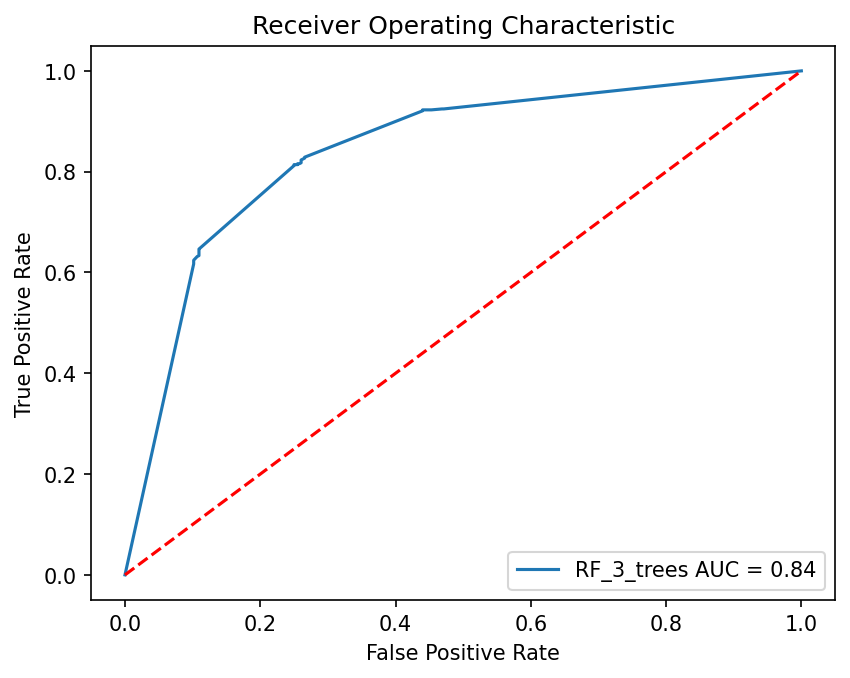

In [69]:
# Store our RF model in a list
model_name = "RF_" + str(number_of_trees) + "_trees"

# Check existing models
index_list = {x["label"] : i for i, x in enumerate(rf_models)}

# Add new model to list
if model_name in index_list:
  rf_models[index_list[model_name]]["model"] = model_RF
else:
  rf_models.append({"label": model_name, "model": model_RF})

# Plot the results of the ROC curve
plot_roc_curves_for_models(rf_models, static_test_x, static_test_y);

**Question:**
* Build a model using several different number of trees in the random forest. Compare the performance of the model using 1 tree, 5 trees, 10 trees, and a 100 trees. Which performs best with regard to sensitivity and ROC?
* Is the performance of the models using 10 trees and 100 trees the same?

**🛑 CHECKPOINT**
*   Verify you have completed all questions in Absalon before continuing
*   If you are completely ready, check the checkbox and continue.

In [ ]:
done_random_forests = False #@param {type:"boolean"}
if not done_random_forests:
  sys.exit()

#### Neural network classifier
The second and last approach we will use here is an artificial neural network model. We train the neural network with X layers, each with Y neurons. You can specify the layers and number of neurons using the sliders. As before, we do the same validation procedure to check the results and create an ROC plot.

For more information on the exact method used (multi-layer perceptron), see [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

**NOTE:** the value displayed next to the sliders isn't always updated correctly, check the code to see if the correct value has been selected!

In [70]:
# Specify model
number_layers = 1 #@param {type:"slider", min:1, max:5, step:1}
number_neurons = 1 #@param {type:"slider", min:1, max:25, step:1}

model_ANN = MLPClassifier(hidden_layer_sizes=([number_neurons] * number_layers), random_state=np.random.RandomState(SEED))

print("Building new neural network using", number_layers, "layers and", number_neurons, "neurons")

performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Building new neural network using 1 layers and 1 neurons
Accuracy: 0.78
Sensitivity: 0.84
Specificity: 0.70
AUC: 0.85


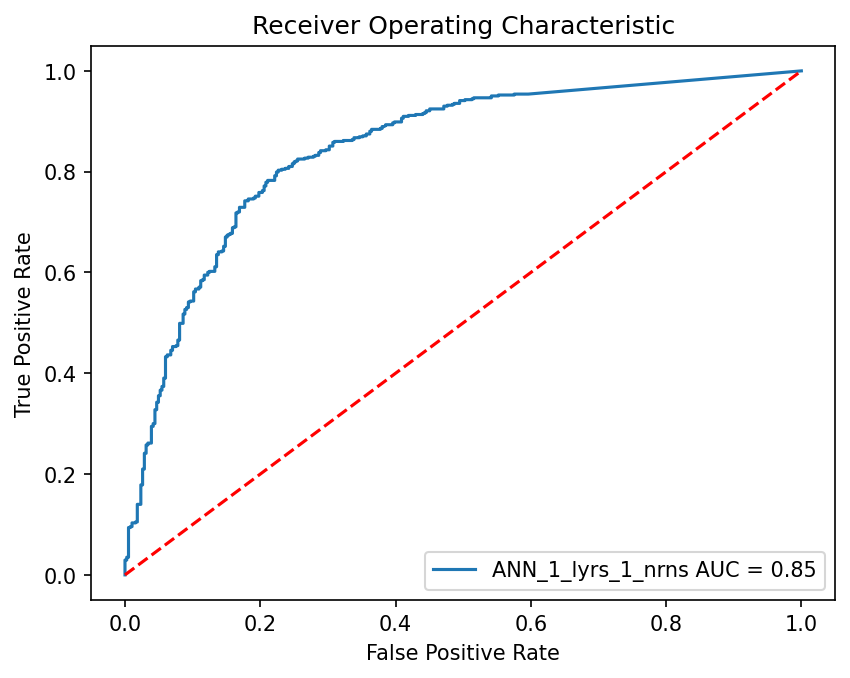

In [71]:
# Store our RF model in a list
model_name = "ANN_" + str(number_layers) + "_lyrs_" + str(number_neurons) + "_nrns"

# Check existing models
index_list = {x["label"] : i for i, x in enumerate(nn_models)}

# Add new model to list
if model_name in index_list:
  nn_models[index_list[model_name]]["model"] = model_RF
else:
  # Append ANN model
  nn_models.append({"label": model_name, "model": model_ANN})

# Plot roc curve
plot_roc_curves_for_models(nn_models, static_test_x, static_test_y, True);

**Questions:**
* Build a model using several different number of layers and neurons in the neural network. Compare the performance for 1 layer with 1/10/20 neurons and repeat the same for 2 and 4 layers. Based on the AUC, what combination of neurons and layers works best?

**DISCUSS:** Once you have found an optimum of layers and neurons, adding more neurons or layers does not significantly impact the prediction anymore. What could be the reason for this?
* EXTRA: Visualize the setup of the best neural network here [NN-SVG](http://alexlenail.me/NN-SVG/index.html). Remember to also correctly represent the input layer.

**🛑 CHECKPOINT**
*   Verify you have completed all questions in Absalon before continuing
*   If you are completely ready, check the checkbox and continue.

In [72]:
done_neural_nets = True #@param {type:"boolean"}
if not done_neural_nets:
  sys.exit()

Your models should show relatively high values for all validation measures (see above). What can we carefully conclude from this?

Read and discuss the folowing

**Questions:**

DISCUSS: look back and summarize the steps you've taken in creating and evaluating your models, starting at the input collection. Are you happy with the results? Are there elements that are missing?  




## Prediction 🪄

Use your favorite molecular drawer to draw a small molecule. Copy the SMILES and paste it in the input below. Then we will try to predict whether or not, this molecule might have affinity for EGFR!

If you don't have molecule sketching software, you can use this online sketcher to draw a molecule [MarvinJS](https://marvinjs-demo.chemaxon.com/latest/). Draw the molecule, then click on the 💾 icon at the top and select SMILES in the dropdown.

In [75]:
new_molecule = "SMILES" #@param {type:"string"}

if new_molecule == "":
  print("ERROR: Please provide a molecule in the form of a SMILES string")
  sys.exit()

In [78]:
  # Let's draw our molecule and inspect if it is correct
  mols2grid.display([Chem.MolFromSmiles('CCC1=CC=CC=C1')])

MolGridWidget()

Now we will calculate the MACCS fingerprint for this molecule.

In [80]:
# Create a dataframe for our new molecule
newmol_df = pd.DataFrame([['CCC1=CC=CC=C1']],columns=["smiles"])
# Calculate the fingerprint for our new molecule
newmol_df["fp"] = newmol_df["smiles"].apply(smiles_to_fp)
# Check if everything is ok
newmol_df.head()

,smiles,fp
0,CCC1=CC=CC=C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Almost there, we are now ready to provide the fingerprint to our trained models and predict the likelyhood of the molecule being an EGFR ligand!
So let's apply our models to our new molecule!!

In [81]:
models = rf_models + nn_models
for model in models:
    print("\n=======")
    print("MODEL:",model["label"])
    prediction = model["model"].predict(newmol_df.fp.to_list())
    if prediction:
      print("Predicted ACTIVE!")
    else:
      print("Predicted INACTIVE!")


MODEL: RF_3_trees
Predicted INACTIVE!

MODEL: ANN_1_lyrs_1_nrns
Predicted INACTIVE!


**Questions:**

* Find the structure/SMILES of gefitinib/Iressa, an approved EGFR inhibitor, by majority voting do our models agree that this molecule is an EGFR inhbitor?
* Find the structure/SMILES of mobocertinib/Exkivity, a recently approved EGFR inhibitor, by majority voting do our models agree that this molecule is an EGFR inhbitor?
* Find the structure/SMILES of doxepin/Quitaxon, an antihistamine, by majority voting is this molecule expected to be an EGFR inhbitor?
* Find the structure/SMILES of sildenafil/Viagra, a PDE inhibitor, by majority voting is this molecule expected to be an EGFR inhbitor?

**🛑 CHECKPOINT**
*   ‼️ Complete the full MC-quiz on Absalon ‼️
*   If you are completely ready, check the checkbox and continue to the closing discussion.

In [82]:
done_notebook = True #@param {type:"boolean"}
if not done_notebook:
  sys.exit()

## Discussion

* Which model performed best on our data set and why?
    * All three models perform (very) well on our dataset. The best models showed a mean AUC of about 90%. Our neural network showed slightly lower results.
    * There might be several reasons why the random forest machine models performed best. Our dataset might be easily separable in active/inactive with some simple tree-like decisions, respectively. Thus, there is not such a complex pattern in the fingerprints to do this classification.
    * A cause for the slightly poorer performance of the ANN could be that there was simply too few data to train the model on. ANNs are infamous for their requirement of a lot of data for training.
* Was the MACCS fingerprint the right choice?
    * Obviously, MACCS was good to start training and validating models to see if a classification is possible.
    * However, MACCS keys are rather short (166 bit) compared to others (2048 bit), as for example Morgan fingerprint. As you might expect, having longer fingerprint can help the learning process.


### Where can we go from here?

* We successfully trained several models.
* The next step could be to use these models to do a classification with an unknown screening dataset to predict novel potential EGFR inhibitors.
* An example for a large screening data set is e.g. [MolPort](https://www.molport.com/shop/database-download) with over 7 million compounds.
* Our models could be used to rank the MolPort compounds and then further study those with the highest predicted probability of being active.
* For such an application, see also the [TDT Tutorial](https://github.com/sriniker/TDT-tutorial-2014) developed by S. Riniker and G. Landrum, where they trained a fusion model to screen [eMolecules](https://www.emolecules.com/) for new anti-malaria drugs.

### References

* "Fingerprints in the RDKit" [slides](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf), G. Landrum, RDKit UGM 2012
* Extended-connectivity fingerprints (ECFPs): Rogers, David, and Mathew Hahn. "Extended-connectivity fingerprints." [_Journal of chemical information and modeling_ 50.5 (2010): 742-754.](https://doi.org/10.1021/ci100050t)
* Machine learning (ML):
  * Random forest (RF): Breiman, L. "Random Forests". [_Machine Learning_ **45**, 5–32 (2001).](https://link.springer.com/article/10.1023%2FA%3A1010933404324)
  * Support vector machines (SVM): Cortes, C., Vapnik, V. "Support-vector networks". [_Machine Learning_ **20**, 273–297 (1995).](https://link.springer.com/article/10.1007%2FBF00994018)
  * Artificial neural networks (ANN): Van Gerven, Marcel, and Sander Bohte. "Artificial neural networks as models of neural information processing." [_Frontiers in Computational Neuroscience_ 11 (2017): 114.](https://doi.org/10.3389/fncom.2017.00114)
* Performance:
  * Sensitivity and specificity ([Wikipedia](https://en.wikipedia.org/wiki/Sensitivity_and_specificity))
  * ROC curve and AUC ([Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve))
* See also [github notebook by B. Merget](https://github.com/Team-SKI/Publications/tree/master/Profiling_prediction_of_kinase_inhibitors) from [*J. Med. Chem.*, 2017, 60, 474−485](https://pubs.acs.org/doi/10.1021/acs.jmedchem.6b01611)
* Activity cutoff $pIC_{50} = 6.3$ (i.e. 500 nM) is used in this practical
  * Profiling Prediction of Kinase Inhibitors: Toward the Virtual Assay [<i>J. Med. Chem.</i> (2017), <b>60</b>, 474-485](https://doi.org/10.1021/acs.jmedchem.6b01611)
  * Notebook accompanying the publication mentioned before: [Notebook](https://github.com/Team-SKI/Publications/blob/master/Profiling_prediction_of_kinase_inhibitors/Build_ABL1_model.ipynb)